# Salary Prediction


## Predict Salaries for Data Scientists using Regression

### 3-22-2022

- **Goal:** This attempts to predict a salary of a data science position based on the web scraped data of [indeed.com](https://www.indeed.com/). The hypothesis is that if the scraped data has enough correlatable features pointing to the target (salary), then there is enough data to predict a fair salary. In contrast, the null hypothesis is that there won’t be a way to predict a salary with the scraped data. For this project, the search term “data scientist” was input into the job site search bar, the results of each page were scraped, and then the job’s company existing employee “work happiness scores” were scraped as well. The data was then added to machine learning models in order to predict a salary based on the position and company scores.

- **Process:** Exploring the data on [indeed.com](https://www.indeed.com/) and feature engineering the results, the fields before using dummy variables for the regression model were:
  - job_title
  - salary
  - company
  - company_rating
  - job_locations_available
  - region
  - happiness
  - flexibility
  - learning
  - achievement
  - appreciation
  - inclusion
  - support
  - purpose
  - energy
  - compensation
  - satisfaction
  - management
  - trust
  - belonging
  - stress-free

  I commented most cells explaining the reason behind doing the commands. This should be able to illustrate my overall mindset on why a method was used. From there, I perfomed some regression modeling and made some visualizations.

- **Visuals**: The visualizations chosen for this data to begin with is a histogram to show the salary data spread, pairplot to show correlations between features, and a linear regression line over a scatter plot. They have an explanation as comments in the cell to state what it does.

* **Conclusion**: It appears most data that I thought was going to be viable wasn't the best decision. The multicollinearity between all features created a very low R² value for all linear models. The RMSE scores were also high. However, it's good to note that even though the features were highly correlated for this project, one could still create models in a similar way for a prediction with features with less correlation.

### Web Scraping

#### Imports

In [1]:
import pandas as pd
import numpy as np
import requests
import io
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.common.exceptions import TimeoutException
from itertools import zip_longest
from time import sleep
from math import sqrt
import re
import time
import random
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV

#### Define Functions

In [ ]:
# put data into a list while addressing None type values
def get_title(titles):
    
    # get the job title for each job
    title_list = []
    try:
        for t in titles:
            title_list.append(t.text)
    except None:
        title_list.append("data_not_available")
    
    title_list = ['' if v is None else v for v in title_list]
    return title_list

In [ ]:
# put data into a list while addressing None type values
def get_location(locations):
    
    # get the location for each job
    location_list = []
    try:
        for location in locations:
            location_list.append(location.text)
    except None:
        location_list.append("data_not_available")
    
    location_list = ['' if v is None else v for v in location_list]
    return location_list

In [ ]:
# put data into a list while addressing None type values
def get_company(companies):
    
    # get the lcoation for each job
    company_list = []
    try:
        for company in companies:
            company_list.append(company.text)
    except None:
        company_list.append("data_not_available")
    
    company_list = ['' if v is None else v for v in company_list]
    return company_list

In [ ]:
# put data into a list while addressing None type values
def get_salary(salaries):
    
    salary_list = []
    for i,v in enumerate(salaries):
        tmp_list = []
        # yearly salary extraction
        if '$' in v.text and 'year' in v.text:
            a = v.text.replace('$', '').replace(',', '')
            for val1 in a.split(" "):
                try:
                    if val1.isdigit():
                        tmp_list.append(int(val1))
                    else:
                        tmp_list.append(0)
                except None:
                    tmp_list.append(0)
            # since some have a range, take only the max value
            salary_list.append(max(tmp_list))

        # hourly pay extraction
        if '$' in v.text and 'hour' in v.text:
            b = v.text.replace('$', '').replace(',', '')
            for val2 in b.split(" "):
                try:
                    if val2.isdigit():
                        tmp_list.append(int(val2))
                    else:
                        tmp_list.append(0)
                    # convert hourly to yearly
                except None:
                    tmp_list.append(0)
            # since some have a range, take only the max value and convert to a yearly salary
            salary_list.append(max(tmp_list) * 40 * 52)
        else:
            salary_list.append("data_not_available")

    salary_list = ['' if v is None else v for v in salary_list]
    return salary_list

In [ ]:
# put data into a list while addressing None type values
def get_link(job_links):
    
    # get the links for each job (this is commented out when being called as it's optional for later)
    link_list = []
    try:
        for links in job_links:
            href = (links['href'])
            new_url = base_url + href
            link_list.append(new_url)
    except None:
        link_list.append("data_not_available")
    
    link_list = ['' if v is None else v for v in link_list]
    return link_list

In [ ]:
# put data into a list while addressing None type values
def get_rating(ratings):

    # get the ratings for each job's company
    rating_list = []
    try:
        for rating in ratings:
            rating_list.append(rating.text)
    except None:
        rating_list.append("data_not_available")
    
    rating_list = ['' if v is None else v for v in rating_list]
    return rating_list

In [ ]:
# put data into a list while addressing None type values
def get_location_counts(location_counts):

    # get the ratings for each job's company
    location_counts_list = []
    try:
        for location_count in location_counts:
            location_counts_list.append(location_count.text)
    except None:
        location_counts_list.append("data_not_available")
    
    location_counts_list = ['' if v is None else v for v in location_counts_list]
    return location_counts_list

In [ ]:
# put data into a list while addressing None type values
def get_desc(job_desc):
    
    # get the links for each job (this is commented out when being called as it's optional for later    
    desc_list = []
    try:
        for desc in job_desc:
            desc_list.append(desc.text)
    except None:
        desc_list.append("data_not_available")
    
    desc_list = ['' if v is None else v for v in desc_list]
    return desc_list

In [2]:
# ref: https://towardsdatascience.com/statistics-in-python-collinearity-and-multicollinearity-4cc4dcd82b3f

def calculate_vif(df, features):    
    vif, tolerance = {}, {}

    # all features wanted in determining target
    for feature in features:
        # extract all the other features you will regress against
        X = [f for f in features if f != feature]        
        X, y = df[X], df[feature]
        # extract r-squared from the fit
        r2 = LinearRegression().fit(X, y).score(X, y)                
        
        # calculate tolerance
        tolerance[feature] = 1 - r2
        # calculate VIF
        vif[feature] = 1/(tolerance[feature])
    # return VIF DataFrame
    return pd.DataFrame({'VIF': vif, 'Tolerance': tolerance})

#### Go get the data from one page and clean it a bit to fit it into a dataframe

In [ ]:
# based on https://www.youtube.com/watch?v=Q_nKKx8L_qE

headers = {"User Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/99.0.4844.51 Safari/537.37"}

base_url = "https://www.indeed.com"
start_url = "https://www.indeed.com/jobs?q=data%20scientist&start={}"

job_list = []
location_list = []
salary_list = []
company_list = []
rating_list = []
location_counts_list = []
link_list = []
desc_list = []

for page_num in range(0, 1000, 10):
    #print(page_num)
    r = requests.get(start_url.format(page_num), headers=headers)
    soup = BeautifulSoup(r.text, 'html.parser')
    titles = soup.find_all(class_="jobTitle")
    locations = soup.find_all(class_="companyLocation")
    salaries = soup.find_all(class_='attribute_snippet')
    companies = soup.find_all(class_="companyName")
    ratings = soup.find_all(class_="ratingNumber")
    location_counts = soup.find_all(class_="more_loc_container")
    links = soup.find_all(class_=re.compile('tapItem fs-unmask result job_'))
    description = soup.find_all(class_="job-snippet")

    job_list.append(get_title(titles))
    location_list.append(get_location(locations))
    salary_list.append(get_salary(salaries))
    company_list.append(get_company(companies))
    rating_list.append(get_rating(ratings))
    location_counts_list.append(get_location_counts(location_counts))
    link_list.append(get_link(links))
    desc_list.append(get_desc(description))

    # wait a little before making next request
    #time.sleep(.725456189 + random.random())

In [ ]:
# combine all lists into one respective list to make it easier to put it into the dataframe
# I tried putting into a list comprehension or a function and failed so sticking with this for now

final_job_list = []
for j in job_list:
    final_job_list += j

final_location_list = []
for l in location_list:
    final_location_list += l

final_salary_list = []
for s in salary_list:
    final_salary_list += s

final_company_list = []
for c in company_list:
    final_company_list += c

final_rating_list = []
for r in rating_list:
    final_rating_list += r

final_location_counts_list = []
for f in location_counts_list:
    final_location_counts_list += f

final_link_list = []
for k in link_list:
    final_link_list += k

final_desc_list = []
for d in desc_list:
    final_desc_list += d

#### Make the dataframe

In [ ]:
# since all data are in lists, make them a tuple for pandas ingestion
#data_tuples = zip(final_job_list, final_location_list, final_salary_list, final_company_list, final_rating_list, final_location_counts_list, final_link_list, final_desc_list)
data_tuples = zip(final_job_list, final_location_list, final_salary_list, final_company_list, final_rating_list, final_location_counts_list)

# create a dataframe with the data tuple
#df = pd.DataFrame(data_tuples, columns=["job_title", "location", "salary", "company", "company_rating", "job_locations_available", "job_link", "job_description"])
df = pd.DataFrame(data_tuples, columns=["job_title", "location", "salary", "company", "company_rating", "job_locations_available"])

# save to csv for later
df.to_csv('indeed_salary_data.csv', mode='a', index=False, header=False)

### EDA and Data Normalization

In [3]:
# set views for notebook
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [4]:
# now that there'a a csv from the scrape, read from that instead
df = pd.read_csv('indeed_salary_data.csv')
df.drop_duplicates(inplace=True)

In [5]:
df.sample(n=5, random_state=42).style

,job_title,location,salary,company,company_rating,job_locations_available
7678,newRemote - Staff /Lead Data Scientist,"Remote in Frisco, TX 75033 75033+6 locations",150000,Shopify,4.100000,+2 locations
8280,"Director, Data Science",Remote,data_not_available,Slack,3.400000,+1 location
9199,Principal Data Scientist,Remote in Colorado+43 locations,data_not_available,Verizon,3.700000,+13 locations
9895,Junior Data Scientist,"Remote in New York, NY",data_not_available,SmartAsset,4.200000,+3 locations
9401,newData Scientist,United States,data_not_available,Fund For Public Health In New York Inc,4.200000,+1 location


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11465 entries, 0 to 11662
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   job_title                11465 non-null  object 
 1   location                 11465 non-null  object 
 2   salary                   11465 non-null  object 
 3   company                  11465 non-null  object 
 4   company_rating           11465 non-null  float64
 5   job_locations_available  11465 non-null  object 
dtypes: float64(1), object(5)
memory usage: 627.0+ KB


In [7]:
df['job_locations_available'].value_counts().head()

+1 location     2966
+2 locations    1837
+4 locations    1186
+3 locations    1003
+6 locations     496
Name: job_locations_available, dtype: int64

In [8]:
# clean df['job_locations_available'] to make it a float
df['job_locations_available'] = \
    df['job_locations_available']\
        .str.replace('locations', '', regex=False)\
        .str.replace('location', '', regex=False)\
        .str.replace('+', '', regex=False)\
        .str.replace(' ', '', regex=False).astype(float)

In [9]:
df.company_rating.describe()

count    11465.000000
mean         3.751409
std          0.532293
min          1.000000
25%          3.500000
50%          3.800000
75%          4.100000
max          5.000000
Name: company_rating, dtype: float64

In [10]:
# check the target
df['salary'].value_counts().head()

data_not_available    9085
150000                 184
160000                 104
120000                 104
180000                  82
Name: salary, dtype: int64

In [11]:
# get only values with a salary and make it a float since there's a lot of "data_not_available"
mask = df['salary'] != "data_not_available"
df = df[mask]
df.reset_index(drop=True, inplace=True)
df['salary'] = df['salary'].astype(float)

In [12]:
df.sample(n=5, random_state=42).style

,job_title,location,salary,company,company_rating,job_locations_available
1413,"IT Specialty Resource/Data Scientist - Richmond, VA (DE1JP00...","Richmond, VA",0.000000,BCP Engineers & Consultants,3.600000,1.000000
2168,"newDoD Senior Data Scientist, Managing Consultant","Jessup, MD 20794 20794+10 locations",141440.000000,Guidehouse,4.200000,97.000000
2002,Data Science Co-Op,"Princeton, NJ+5 locations",170000.000000,Bristol Myers Squibb,3.400000,24.000000
1996,Lead/Principal Data Scientist,+9 locationsRemote,197600.000000,Salesforce,3.700000,1.000000
1103,Senior Statistical Programmer,"Carolina, PR+2 locations",150000.000000,Worldwide Clinical Trials - USA,3.300000,3.000000


In [13]:
# clean the df['job_title'] column
df['job_title'] = df['job_title'].str.lower()

df['job_title'] = df['job_title']\
    .replace('^new', '', regex=True)\
    .replace('\(all levels\)|\(remote\)', '', regex=True)\
    .replace('^ ', '', regex=True)\
    .replace(' $', '', regex=True)

In [14]:
# clean the df['location'] column to start extracting only states
df['location'] = df['location'].str.lower()
df['location'] =\
    df['location']\
        .replace('\+[0-9]{1,}? location(.)?', '', regex=True)\
        .replace('remote in.*', 'remote', regex=True)\
        .replace('temporarily', '', regex=True)\
        .replace('^emote', 'remote', regex=True)\
        .replace('hybrid', '', regex=True)\
        .replace('\(downtownarea\)', '', regex=True)\
        .replace(',?\s(\w+)?([-\d]+).*', '', regex=True)\
        .replace('united states', 'remote', regex=False)\
        .replace('remote', 'remote, remote', regex=False)\
        .replace('^ ', '', regex=True)\
        .replace(' $', '', regex=True)

In [15]:
# dictionary for all state to state abbreviations
# thanks to https://gist.github.com/rogerallen/1583593

state_convert = {'alabama': 'al',
    'alaska': 'ak',
    'arizona': 'az',
    'arkansas': 'ar',
    'california': 'ca',
    'colorado': 'co',
    'connecticut': 'ct',
    'delaware': 'de',
    'florida': 'fl',
    'georgia': 'ga',
    'hawaii': 'hi',
    'idaho': 'id',
    'illinois': 'il',
    'indiana': 'in',
    'iowa': 'ia',
    'kansas': 'ks',
    'kentucky': 'ky',
    'louisiana': 'la',
    'maine': 'me',
    'maryland': 'md',
    'massachusetts': 'ma',
    'michigan': 'mi',
    'minnesota': 'mn',
    'mississippi': 'ms',
    'missouri': 'mo',
    'montana': 'mt',
    'nebraska': 'ne',
    'nevada': 'nv',
    'new hampshire': 'nh',
    'new jersey': 'nj',
    'new mexico': 'nm',
    'new york': 'ny',
    'north carolina': 'nc',
    'north dakota': 'nd',
    'ohio': 'oh',
    'oklahoma': 'ok',
    'oregon': 'or',
    'pennsylvania': 'pa',
    'rhode island': 'ri',
    'south carolina': 'sc',
    'south dakota': 'sd',
    'tennessee': 'tn',
    'texas': 'tx',
    'utah': 'ut',
    'vermont': 'vt',
    'virginia': 'va',
    'washington': 'wa',
    'west virginia': 'wv',
    'wisconsin': 'wi',
    'wyoming': 'wy',
    'district of columbia': 'dc',
    'american samoa': 'as',
    'guam': 'gu',
    'northern mariana islands': 'mp',
    'puerto rico': 'pr',
    'united states minor outlying islands': 'um',
    'u.s. virgin islands': 'vi'
    }

In [16]:
df.sample(n=5, random_state=42).style

,job_title,location,salary,company,company_rating,job_locations_available
1413,"it specialty resource/data scientist - richmond, va (de1jp00...","richmond, va",0.000000,BCP Engineers & Consultants,3.600000,1.000000
2168,"dod senior data scientist, managing consultant","jessup, md",141440.000000,Guidehouse,4.200000,97.000000
2002,data science co-op,"princeton, nj",170000.000000,Bristol Myers Squibb,3.400000,24.000000
1996,lead/principal data scientist,"remote, remote",197600.000000,Salesforce,3.700000,1.000000
1103,senior statistical programmer,"carolina, pr",150000.000000,Worldwide Clinical Trials - USA,3.300000,3.000000


In [17]:
# match up entire state names and replace with the state abbreviation based on the dictionary
df['location'] = df['location'].replace(state_convert)

In [18]:
# based on https://datascienceparichay.com/article/pandas-split-column-by-delimiter/
# split column and add new columns to df
df[['city', 'state']] = df['location'].str.split(',', expand=True)
df['city'] = df['city'].astype(str)
df['state'] = df['state'].astype(str)

In [19]:
# if there's a None value in the df['state'] column, replace it with the city column as it had a state to being with and no city
# thanks https://stackoverflow.com/questions/39903090/efficiently-replace-values-from-a-column-to-another-column-pandas-dataframe

df['state'][df['state'] == 'None'] = df['city']

# drop columns not needed anymore
df.drop(columns=['location', 'city'], inplace=True)

/var/folders/tp/d_3ffh5127l6t9cx918sddb00000gq/T/ipykernel_20353/4047493820.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['state'][df['state'] == 'None'] = df['city']


In [20]:
# get the regions per state (east, west, etc.)
# https://github.com/cphalpert/census-regions/blob/master/us%20census%20bureau%20regions%20and%20divisions.csv

state_regions = pd.read_csv('state_regions.csv')
state_regions = state_regions[['state_code', 'region']]
state_regions = state_regions.set_index('state_code')['region'].to_dict()

In [21]:
# final cleaning of state and convert to region
df['state'] =\
    df['state']\
    .replace(' *','', regex=True)\
    .replace('\(downtownarea\)', '', regex=True)\
    .replace(state_regions)

# I don't want Puerto Rico for this
df['state'] = df['state'][df['state'] != 'pr']

# finally, rename the column to region
df.rename(columns={'state': 'region'}, inplace=True)

In [22]:
# check it
df.sample(n=5, random_state=42).style

,job_title,salary,company,company_rating,job_locations_available,region
1413,"it specialty resource/data scientist - richmond, va (de1jp00...",0.000000,BCP Engineers & Consultants,3.600000,1.000000,south
2168,"dod senior data scientist, managing consultant",141440.000000,Guidehouse,4.200000,97.000000,south
2002,data science co-op,170000.000000,Bristol Myers Squibb,3.400000,24.000000,northeast
1996,lead/principal data scientist,197600.000000,Salesforce,3.700000,1.000000,remote
1103,senior statistical programmer,150000.000000,Worldwide Clinical Trials - USA,3.300000,3.000000,nan


In [23]:
# make the title more standarized
df.loc[df['job_title'].str.contains(r'data scien', na=True), 'job_title'] = "data scientist"
df.loc[df['job_title'].str.contains(r'data ana| ana', na=True), 'job_title'] = "data analyst"
df.loc[df['job_title'].str.contains(r'statistic|statistician|stat ', na=True), 'job_title'] = "statistician"
df.loc[df['job_title'].str.contains(r'engineer|ux dev|application dev|dashboard|risk aud', na=True), 'job_title'] = "data engineer"
df.loc[df['job_title'].str.contains(r'manager', na=True), 'job_title'] = "data science / ml manager"
df.loc[df['job_title'].str.contains(r'machine', na=True), 'job_title'] = "machine learning engineer"
df.loc[df['job_title'].str.contains(r'sales|deals', na=True), 'job_title'] = "data science sales"
df.loc[df['job_title'].str.contains(r'lake', na=True), 'job_title'] = "data lake engineer"
df.loc[df['job_title'].str.contains(r'president|avp|director', na=True), 'job_title'] = "data science / ml vp"
df.loc[df['job_title'].str.contains(r'algorithm dev|senior math', na=True), 'job_title'] = "mathematician"
df.loc[df['job_title'].str.contains(r' ai|ai/ml|ml/ai| ?nlp ?|data |scientist|deep | modeler|natural language proc|decision sci', na=True), 'job_title'] = "data scientist"

In [24]:
df['job_title'].value_counts()

data scientist               2033
statistician                  262
machine learning engineer      80
mathematician                   5
Name: job_title, dtype: int64

In [25]:
df.sample(n=5, random_state=42).style

,job_title,salary,company,company_rating,job_locations_available,region
1413,data scientist,0.000000,BCP Engineers & Consultants,3.600000,1.000000,south
2168,data scientist,141440.000000,Guidehouse,4.200000,97.000000,south
2002,data scientist,170000.000000,Bristol Myers Squibb,3.400000,24.000000,northeast
1996,data scientist,197600.000000,Salesforce,3.700000,1.000000,remote
1103,statistician,150000.000000,Worldwide Clinical Trials - USA,3.300000,3.000000,nan


#### Using the base_url, use selenium to go to the page, click on the "See full report" button to expand it out, and parse the results

In [ ]:
# get a list of all companies
all_companies = df['company'].unique().tolist()
existing_company_data_list = pd.read_csv('company_ratings.csv')['Company'].to_list()

# https://www.csestack.org/compare-two-lists-python-return-non-match-elements/

non_match_a  = set(all_companies) - set(existing_company_data_list)
non_match_b  = set(existing_company_data_list) - set(all_companies)
companies = list(non_match_a) + list(non_match_b)

In [ ]:
list_of_dicts = []

for company in companies:
    try:
        # create object for chrome options
        chrome_options = Options()
        base_url = 'https://www.indeed.com/cmp/{}'.format(company)

        chrome_options.add_argument('disable-notifications')
        chrome_options.add_argument('--disable-infobars')
        chrome_options.add_experimental_option("prefs", {"profile.default_content_setting_values.notifications": 2})
        driver = webdriver.Chrome('chromedriver', options = chrome_options)
        driver.get(base_url)
        delay = 3

        # click into page to get the full report
        driver.find_element_by_xpath('//*[@id="cmp-container"]/div/div[1]/main/div[2]/div[1]/section/div/div/button').click()
        happy_scores = driver.find_element_by_xpath('//*[@id="cmp-container"]/div/div[1]/main/div[2]/div[1]/section/div/div/div[2]').text

        my_list = []
        for line in io.StringIO(happy_scores):
            my_list.append(line.rstrip('\n'))

        # https://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks
        # split into chunks
        my_list = list(zip_longest(*[iter(my_list)]*2, fillvalue=None))
        my_list = my_list[0::2]

        # https://stackoverflow.com/questions/13384841/swap-values-in-a-tuple-list-inside-a-list-in-python
        my_list = [(t[1], t[0]) for t in my_list]

        my_list.append(("Company", company))
        list_of_dicts.append(dict(my_list))
        driver.close()
    except:
        pass

In [ ]:
# list_of_dicts to csv instead of going to get it over and over again
pd.DataFrame.from_dict(list_of_dicts).to_csv('company_ratings.csv', mode='a')

#### Merge original and company rating dataframes

In [26]:
# from the csv created for the company ratings, use it
happy_df = pd.read_csv('company_ratings.csv')
happy_df.columns = happy_df.columns.str.lower()

In [27]:
happy_df.columns

Index(['unnamed: 0', 'work happiness score', 'flexibility', 'learning',
       'achievement', 'appreciation', 'inclusion', 'support', 'purpose',
       'energy', 'compensation', 'satisfaction', 'management', 'trust',
       'belonging', 'stress-free', 'company'],
      dtype='object')

In [28]:
# remove unnamed column and rename happiness
del happy_df['unnamed: 0']
happy_df.rename(columns={"work happiness score": "happiness"}, inplace=True)

In [29]:
df = df.merge(happy_df, how='left', on="company").reset_index(drop=True)

#### Make the salary data more even by removing outliers

<AxesSubplot:xlabel='salary', ylabel='Count'>

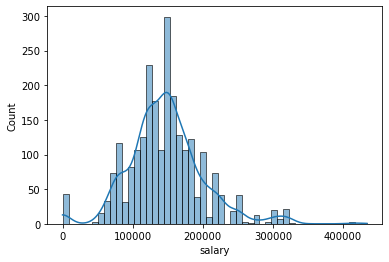

In [30]:
# view a histogram to see the distribution of salary
sns.histplot(df['salary'], kde=True)

In [31]:
print(df.salary.min())
print(df.salary.max())

0.0
434000.0


In [32]:
# since the data is skewed right a little, specify percentiles to remove
lowq = df.salary.quantile(q=0.03)
highq = df.salary.quantile(q=0.97)

In [33]:
df.dropna(inplace=True)
df = df[df.salary > lowq].reset_index(drop=True)
df = df[df.salary < highq].reset_index(drop=True)

In [34]:
print(df.salary.min())
print(df.salary.max())

65000.0
249600.0


<AxesSubplot:xlabel='salary', ylabel='Count'>

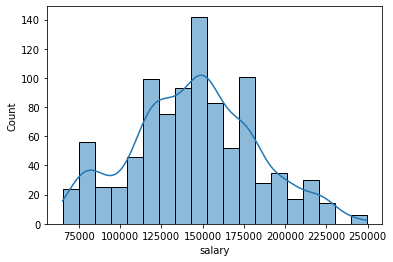

In [35]:
# view a histogram to see the distribution of salary
sns.histplot(df['salary'], kde=True)

In [36]:
convert_col = {
    'happiness': float, 
    'flexibility': float, 
    'learning': float, 
    'achievement': float, 
    'appreciation': float, 
    'inclusion': float, 
    'support': float, 
    'purpose': float, 
    'energy': float, 
    'compensation': float, 
    'satisfaction': float, 
    'management': float, 
    'trust': float, 
    'belonging': float, 
    'stress-free': float
    }

In [37]:
df = df.astype(convert_col)

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 951 entries, 0 to 950
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   job_title                951 non-null    object 
 1   salary                   951 non-null    float64
 2   company                  951 non-null    object 
 3   company_rating           951 non-null    float64
 4   job_locations_available  951 non-null    float64
 5   region                   951 non-null    object 
 6   happiness                951 non-null    float64
 7   flexibility              951 non-null    float64
 8   learning                 951 non-null    float64
 9   achievement              951 non-null    float64
 10  appreciation             951 non-null    float64
 11  inclusion                951 non-null    float64
 12  support                  951 non-null    float64
 13  purpose                  951 non-null    float64
 14  energy                   9

### Feature Engineering

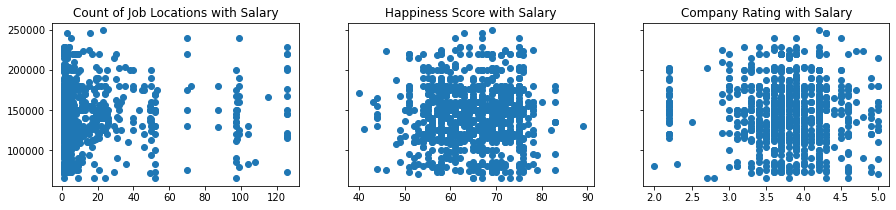

In [39]:
# ref: 365 Data Science - Linear Regression Practical Example (Part 5)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize =(15,3)) #sharey -> share 'salary' as y
ax1.scatter(df['job_locations_available'],df['salary'])
ax1.set_title('Count of Job Locations with Salary')

ax2.scatter(df['happiness'],df['salary'])
ax2.set_title('Happiness Score with Salary')

ax3.scatter(df['company_rating'],df['salary'])
ax3.set_title('Company Rating with Salary')
plt.show()

In [40]:
#df_orig = df.copy(deep=True)

# revert
#df = df_orig.copy(deep=True)

df.head()

,job_title,salary,company,company_rating,job_locations_available,region,happiness,flexibility,learning,achievement,appreciation,inclusion,support,purpose,energy,compensation,satisfaction,management,trust,belonging,stress-free
0,data scientist,175000.0,Oracle,3.2,1.0,remote,65.0,77.0,71.0,70.0,70.0,69.0,69.0,67.0,64.0,64.0,63.0,63.0,63.0,61.0,57.0
1,data scientist,90000.0,The J. M. Smucker Company,3.8,9.0,remote,55.0,55.0,60.0,62.0,61.0,55.0,59.0,59.0,56.0,69.0,54.0,52.0,52.0,50.0,58.0
2,data scientist,124800.0,Starbucks,3.9,4.0,remote,65.0,72.0,68.0,70.0,75.0,73.0,73.0,70.0,67.0,60.0,64.0,64.0,66.0,65.0,46.0
3,data scientist,90000.0,Salesforce,4.1,3.0,remote,76.0,84.0,80.0,78.0,82.0,79.0,80.0,78.0,74.0,82.0,75.0,75.0,76.0,74.0,58.0
4,data scientist,155000.0,Nordstrom Inc,3.7,17.0,remote,67.0,69.0,68.0,72.0,71.0,68.0,70.0,70.0,68.0,67.0,64.0,65.0,64.0,64.0,56.0


In [41]:
# create dummy variables on region
df = pd.get_dummies(df, columns=['region', 'job_title'], drop_first=True, dtype=float)

# dropping company as it's too much noise for this project (talked with Lisa)
df.drop(columns=['company'], inplace=True)

In [42]:
# how is the data correlated to salary
# looking for 0.5 and greater to remove - only between features and not including target
df.corr().sort_values(by='salary', ascending=False)

,salary,company_rating,job_locations_available,happiness,flexibility,learning,achievement,appreciation,inclusion,support,purpose,energy,compensation,satisfaction,management,trust,belonging,stress-free,region_northeast,region_remote,region_south,region_west,job_title_machine learning engineer,job_title_mathematician,job_title_statistician
salary,1.000000,-0.042761,0.026131,-0.007164,0.054647,0.000325,-0.011586,-0.018276,-0.005722,-0.019273,-0.007609,-0.024221,-0.015089,-0.020620,-0.025735,-0.006284,-0.017618,0.001580,0.010297,0.003075,-0.037105,0.028591,-0.002561,0.030229,0.048723
flexibility,0.054647,-0.048266,-0.027520,0.778005,1.000000,0.691377,0.746629,0.651133,0.745041,0.584085,0.765147,0.777044,0.543711,0.709122,0.622893,0.742814,0.717165,0.526896,0.004155,-0.080195,-0.050883,0.153020,0.088053,0.018303,0.168275
job_title_statistician,0.048723,-0.026407,-0.054860,-0.058869,0.168275,0.045945,0.040020,0.073844,-0.026586,0.044832,0.012690,-0.018462,0.000075,-0.150247,0.092535,0.042915,0.016201,0.201247,0.126251,-0.125513,0.007667,-0.123494,-0.063070,-0.009765,1.000000
job_title_mathematician,0.030229,0.075282,-0.003348,0.020310,0.018303,0.014923,0.011892,0.019417,0.012697,0.019172,0.021352,0.011093,0.026878,0.021052,0.014914,0.017853,0.015013,0.007766,-0.014262,-0.018325,-0.020218,0.060945,-0.006798,1.000000,-0.009765
region_west,0.028591,-0.033197,0.018984,0.226671,0.153020,0.194109,0.181830,0.151598,0.239697,0.138603,0.210342,0.223789,0.167926,0.217768,0.118646,0.206146,0.223392,0.066554,-0.234009,-0.300675,-0.331739,1.000000,-0.048405,0.060945,-0.123494
job_locations_available,0.026131,-0.040316,1.000000,-0.016489,-0.027520,-0.011863,-0.019545,-0.031647,-0.009920,-0.031463,-0.007249,-0.009777,-0.031194,0.002708,-0.040435,-0.019754,-0.010085,-0.014806,0.029809,0.017131,-0.018736,0.018984,-0.026210,-0.003348,-0.054860
region_northeast,0.010297,0.012208,0.029809,0.004346,0.004155,0.031171,0.032582,0.036794,0.015912,0.030489,0.045158,0.004884,0.053164,0.006779,0.060502,0.020379,0.031548,-0.001762,1.000000,-0.248272,-0.273922,-0.234009,0.135412,-0.014262,0.126251
region_remote,0.003075,0.021898,0.017131,-0.113360,-0.080195,-0.099659,-0.092723,-0.078796,-0.076680,-0.059030,-0.131557,-0.123514,-0.109963,-0.084132,-0.057611,-0.088705,-0.104722,-0.064818,-0.248272,1.000000,-0.351959,-0.300675,-0.106116,-0.018325,-0.125513
stress-free,0.001580,0.009803,-0.014806,0.542447,0.526896,0.278829,0.418921,0.252038,0.306432,0.185434,0.448196,0.565564,0.251382,0.404224,0.236735,0.331928,0.346737,1.000000,-0.001762,-0.064818,-0.006299,0.066554,0.076506,0.007766,0.201247
learning,0.000325,-0.009813,-0.011863,0.870232,0.691377,1.000000,0.901431,0.947014,0.926782,0.931669,0.904819,0.855871,0.824648,0.869974,0.919105,0.946335,0.949006,0.278829,0.031171,-0.099659,-0.033335,0.194109,0.051011,0.014923,0.045945


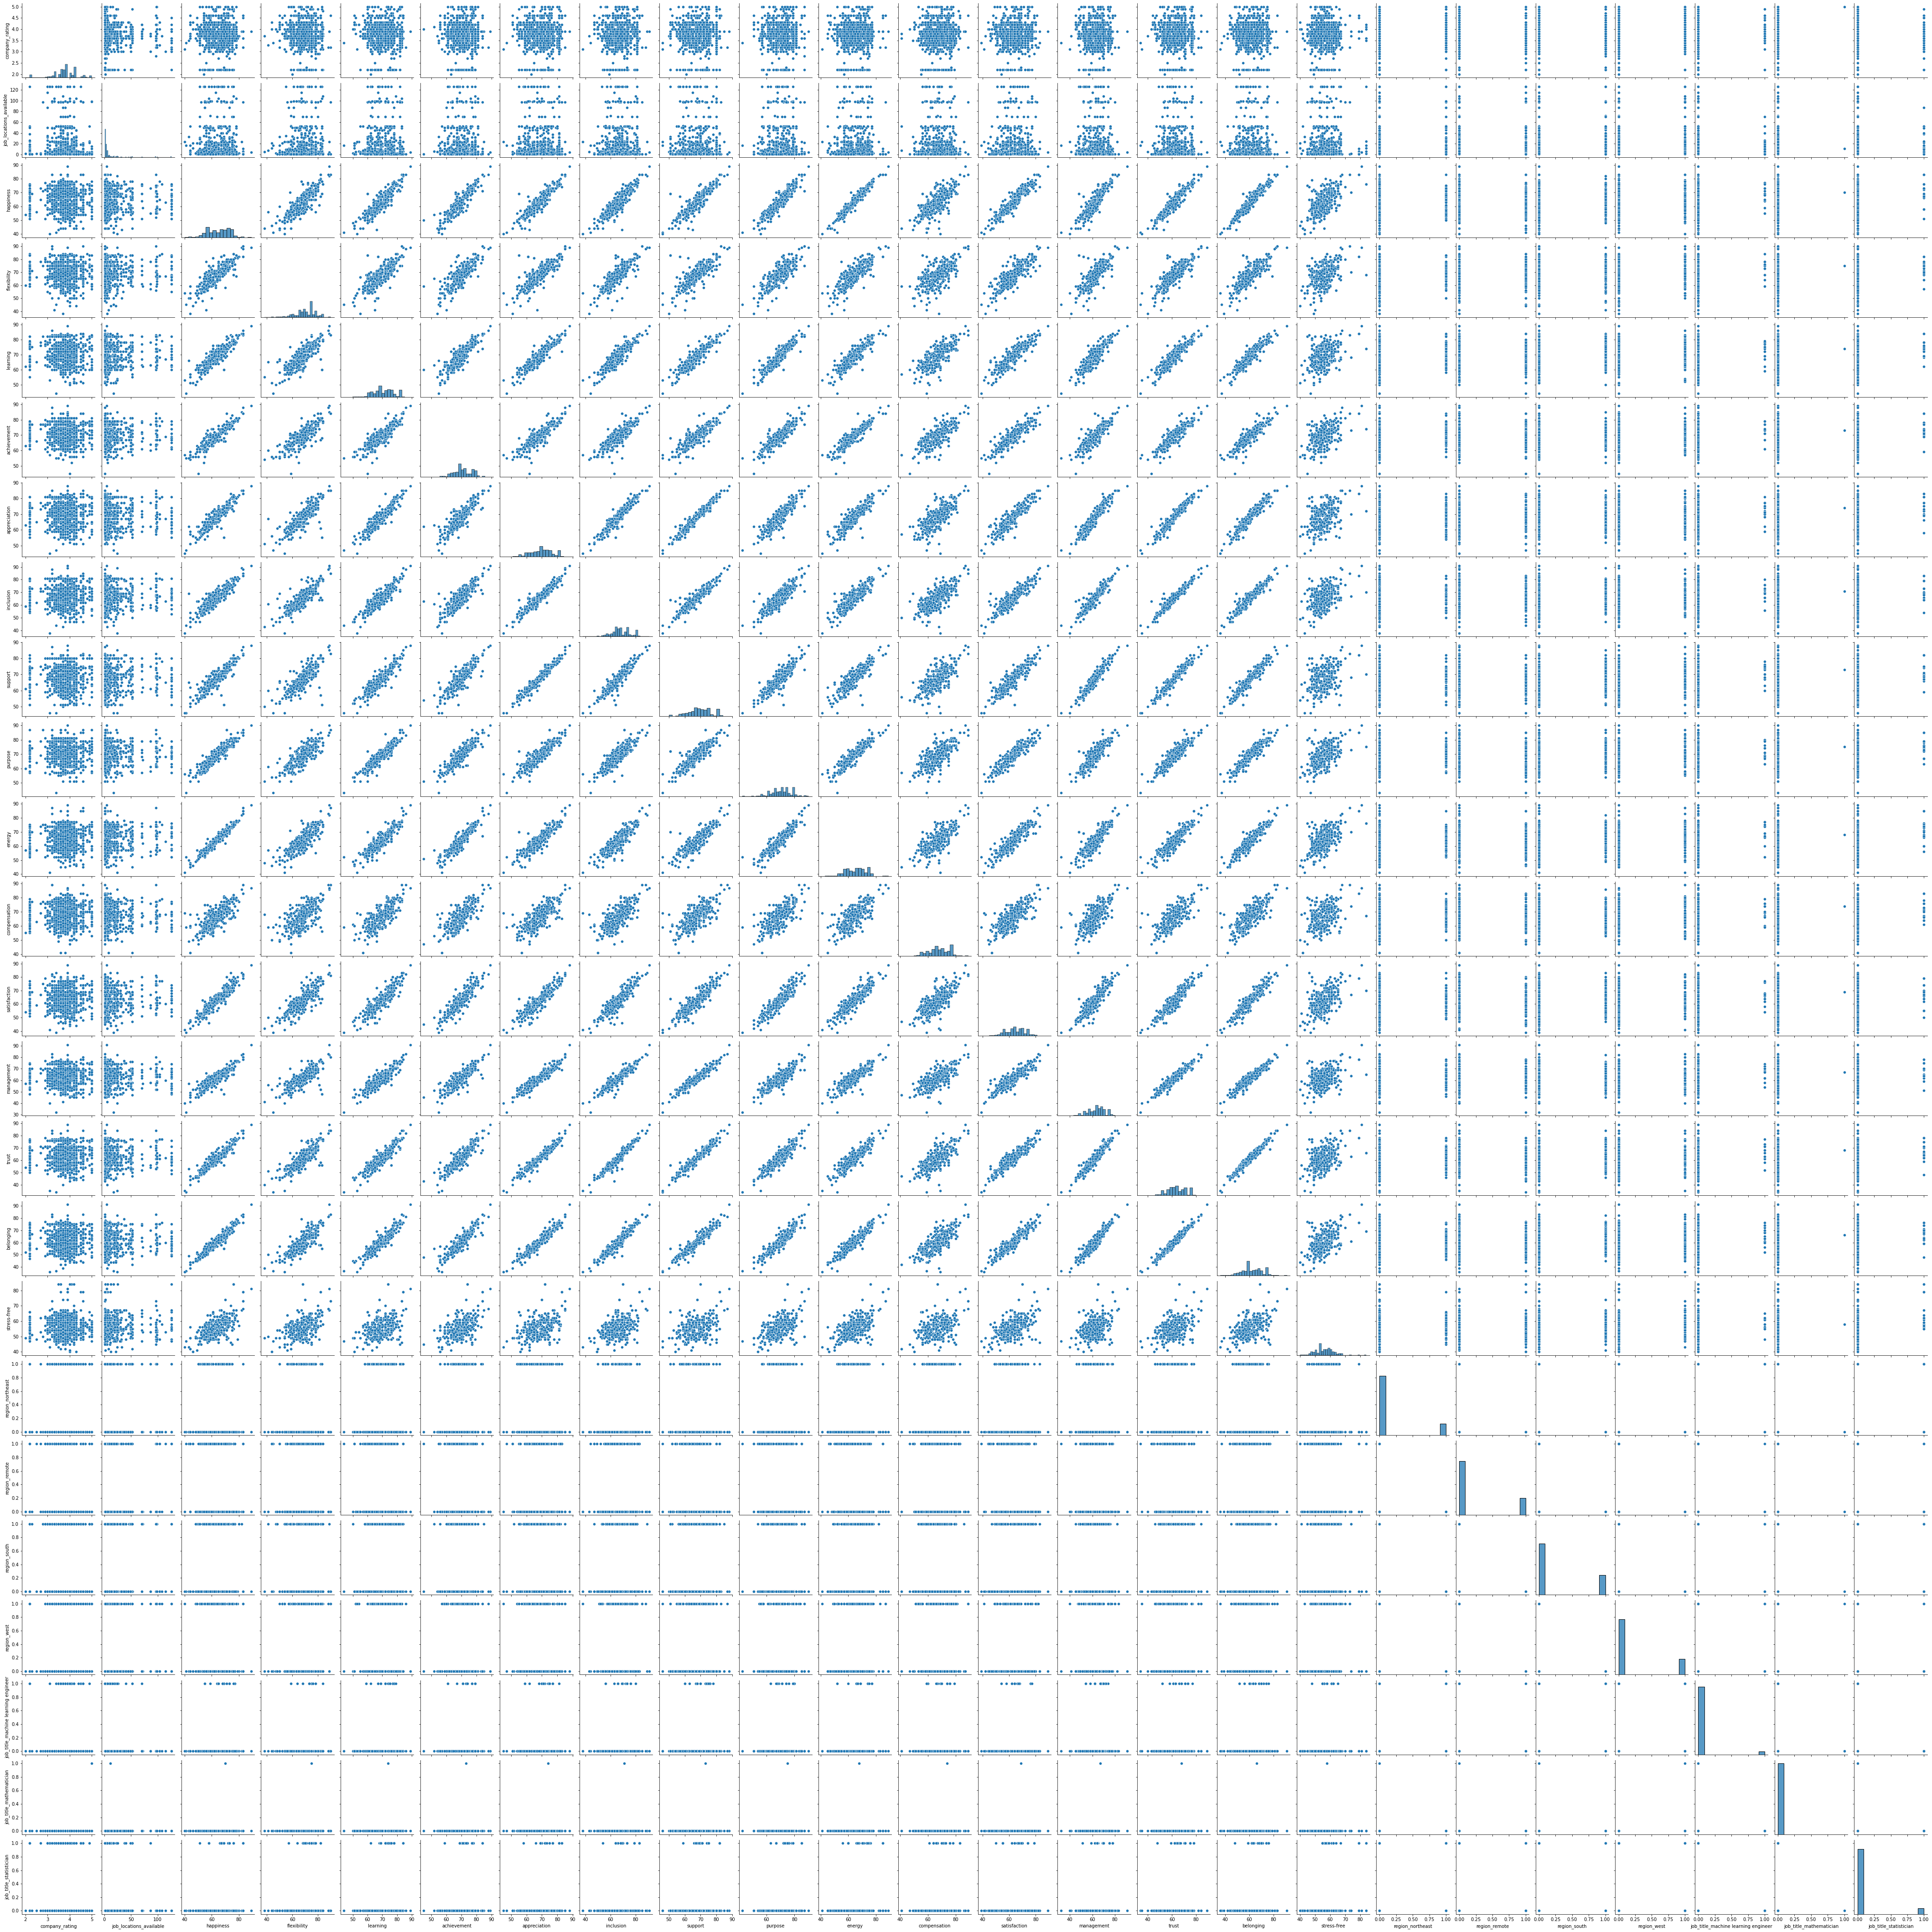

In [43]:
sns.pairplot(df.drop(columns=['salary']))

#### Check for Multicollinearity

##### Method: Variance Inflation Factor (VIF)

In [44]:
features = [
   'company_rating',
   'job_locations_available',
#   'happiness',
   'flexibility',
#   'learning',
   'achievement',
#   'appreciation',
#   'inclusion',
#   'support',
   'purpose',
#   'energy',
   'compensation',
#   'satisfaction',
   'management',
#   'trust',
#   'belonging',
   'stress-free',
   'region_northeast',
   'region_remote',
   'region_south',
   'region_west',
   'job_title_machine learning engineer',
   'job_title_mathematician',
   'job_title_statistician'
   ]

In [45]:
# process: calculate and then view the VIF
# start commenting out the highest VIFs one by one until all other VIFs are in an acceptable range (< 10)

calculate_vif(df=df, features=features).sort_values(by='VIF', ascending=False)#.index.to_list()

,VIF,Tolerance
achievement,9.200204,0.108693
purpose,8.058487,0.124093
management,5.751077,0.173880
compensation,3.434639,0.291151
flexibility,3.011572,0.332052
region_south,2.956811,0.338202
region_remote,2.853319,0.350469
region_west,2.836337,0.352567
region_northeast,2.362980,0.423194
stress-free,1.633588,0.612150


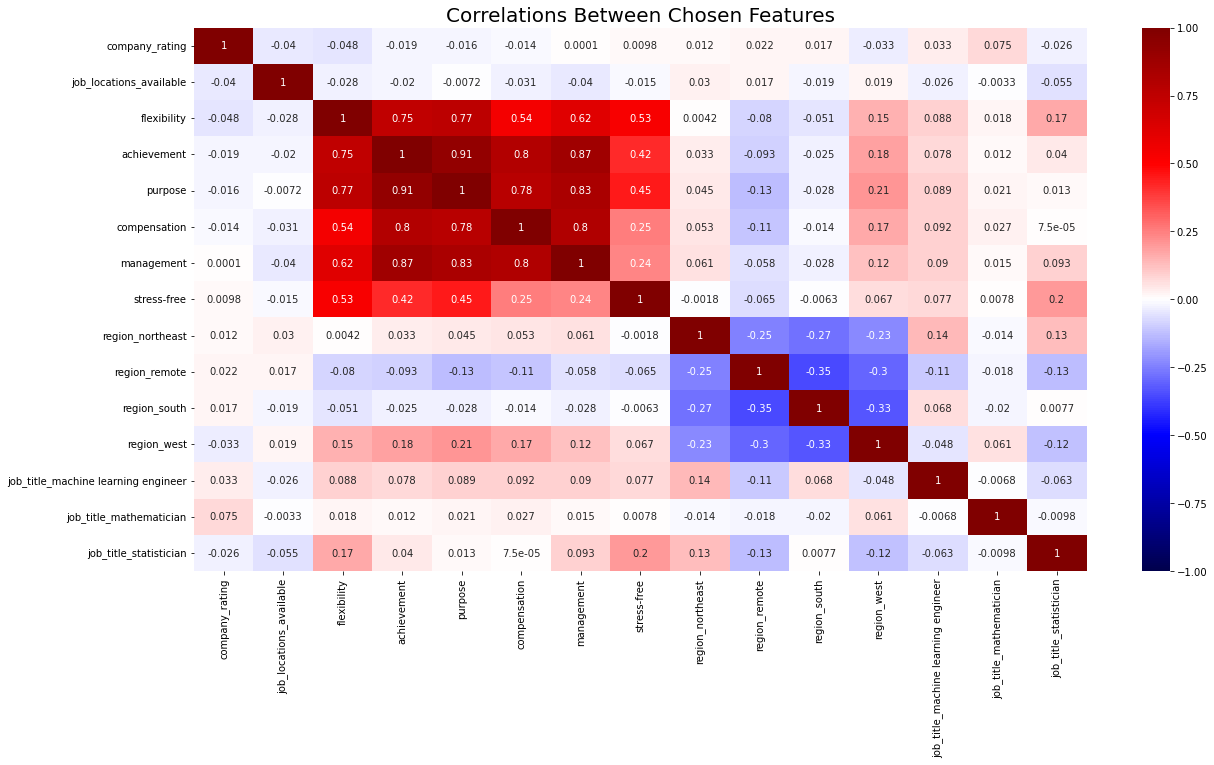

In [46]:
plt.figure(figsize=(20,10))
ax = sns.heatmap(df[features].corr(),cmap="seismic", annot=True, vmin=-1, vmax=1)

ax.set_title("Correlations Between Chosen Features", fontsize=20);

### Modeling

In [47]:
# ref: lesson on cross-validation and regression exercises
# NOTES: fit AND score on train, scoring only (not fit) on validation

y = df['salary'] # target
X = df[features] # features

In [48]:
# ref: validation_workflow_and_utilities from cross-validate lessons
# 80/20 split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [49]:
# print shape for reference in case of shape errors later
print(X.shape, y.shape)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(951, 15) (951,)
(760, 15) (760,)
(191, 15) (191,)


#### Linear Regression

In [50]:
# ref: regression_practice_solution

model = LinearRegression()
lr = model.fit(X_train,y_train)

r2_train_l = lr.score(X_train, y_train)
r2_test_l = lr.score(X_test, y_test)

#r2_adj_train_l = 1 - (1-lr.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
#r2_adj_test_l = 1 - (1-lr.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)

y_pred_train_l = lr.predict(X_train)
y_pred_test_l = lr.predict(X_test)

rsme_training_data_l = sqrt(mean_squared_error(y_train, y_pred_train_l))
rsme_test_data_l = sqrt(mean_squared_error(y_test, y_pred_test_l))

y_pred_train_l.shape, y_pred_test_l.shape

((760,), (191,))

In [51]:
print(f"R² training score: {r2_train_l}")
print(f"R² test score: {r2_test_l}")
#print(f"Adjusted R² training score: {r2_adj_train_l}")
#print(f"Adjusted R² test score: {r2_adj_test_l}")
print(f"RMSE on training data: {rsme_training_data_l}")
print(f"RMSE on test data: {rsme_test_data_l}")

R² training score: 0.024387111752781188
R² test score: -0.044251304698792016
RMSE on training data: 37464.21066351763
RMSE on test data: 37294.7512537418


#### Polynomial

In [52]:
# Create polynomial features
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)

# Apply polynomial transformation to test set
X_test_poly = poly.transform(X_test)

# Fit a model using polynomial features
lr_poly = LinearRegression()
lr_poly.fit(X_train_poly,y_train)

r2_train_p = lr_poly.score(X_train_poly,y_train)
r2_test_p = lr_poly.score(X_test_poly, y_test)

y_pred_train_p = lr_poly.predict(X_train_poly)
y_pred_test_p = lr_poly.predict(X_test_poly)

rsme_training_data_p = sqrt(mean_squared_error(y_train, y_pred_train_p))
rsme_test_data_p = sqrt(mean_squared_error(y_test, y_pred_test_p))

In [53]:
print(f"R² training score: {r2_train_p}")
print(f"R² test score: {r2_test_p}")
print(f"RMSE on training data: {rsme_training_data_p}")
print(f"RMSE on test data: {rsme_test_data_p}")

R² training score: -0.22704916007035525
R² test score: -1.2843876243549355
RMSE on training data: 42015.42913247269
RMSE on test data: 55160.74218439115


#### LassoCV

In [54]:
# Don't forget to standard scale your data for regularized regression
scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)

# Apply the same scaler to val set
X_val_test_scaled = scaler.transform(X_test_poly)

# Fit a LASSO model using polynomial features
import warnings
warnings.filterwarnings('ignore')
lasso = LassoCV()
lasso.fit(X_train_poly_scaled,y_train)

r2_train_las = lasso.score(X_train_poly_scaled,y_train)
r2_test_las = lasso.score(X_val_test_scaled, y_test)

y_pred_train_las = lasso.predict(X_train_poly)
y_pred_test_las = lasso.predict(X_val_test_scaled)

rsme_training_data_las = sqrt(mean_squared_error(y_train, y_pred_train_las))
rsme_test_data_las = sqrt(mean_squared_error(y_test, y_pred_test_las))

In [55]:
print(f"R² training score: {r2_train_las}")
print(f"R² test score: {r2_test_las}")
print(f"RMSE on training data: {y_pred_train_las[0]}")
print(f"RMSE on test data: {y_pred_test_las[0]}")

R² training score: 0.0010539484858531623
R² test score: -0.018893688888245164
RMSE on training data: 145881.72763157895
RMSE on test data: 145833.54174456277


#### Ridge

R² training score: 0.0241370488219681
R² test score: -0.043735956434078016
RMSE on training data: 139102.2838013116
RMSE on test data: 147436.2139067333
----------------
Intercept: 147476.39950021522
----------------
job_title_mathematician                16080.738437
region_northeast                        7516.322298
job_title_statistician                  7393.872452
region_west                             7232.830250
region_remote                           5991.498914
job_title_machine learning engineer     4417.825738
region_south                            1630.261903
flexibility                              916.961818
compensation                             193.285864
job_locations_available                   28.637847
purpose                                 -197.208840
stress-free                             -256.032581
achievement                             -296.403414
management                              -511.095248
company_rating                          -947.925923
dty

Text(0.5, 1.0, 'Salary Count Spread')

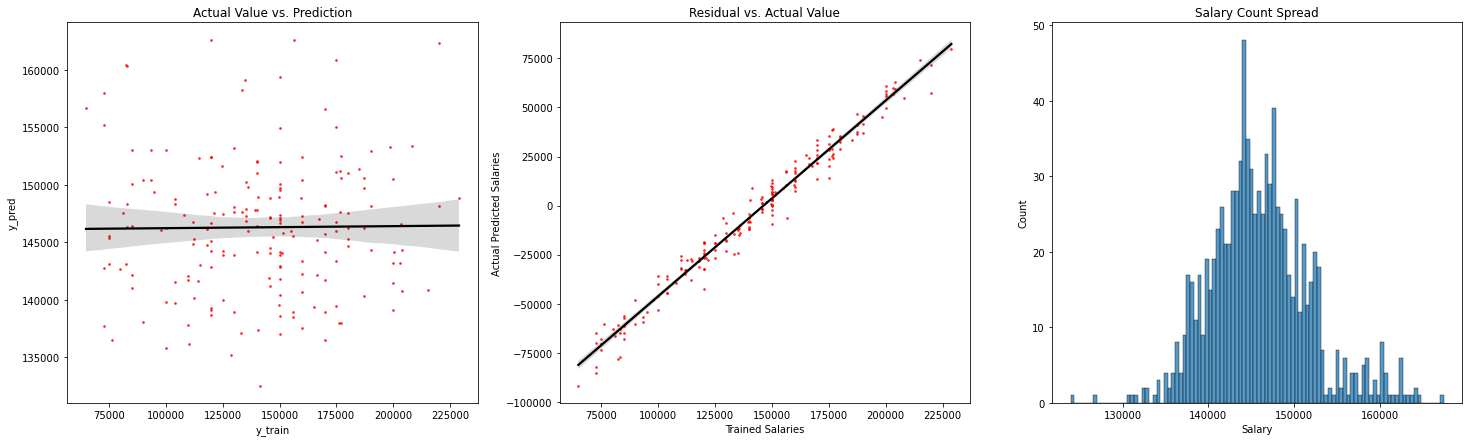

In [58]:
# based on https://www.kaggle.com/code/jack89roberts/top-7-using-elasticnet-with-interactions/notebook

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

# fit model
lr = Ridge()
lr.fit(X_train, y_train)

r2_train_r = lr.score(X_train, y_train)
r2_test_r = lr.score(X_test, y_test)

y_pred_train_r = lr.predict(X_train)
y_pred_test_r = lr.predict(X_test)

rsme_training_data_r = sqrt(mean_squared_error(y_train, y_pred_train_r))
rsme_test_data_r = sqrt(mean_squared_error(y_test, y_pred_test_r))

print(f"R² training score: {r2_train_r}")
print(f"R² test score: {r2_test_r}")
print(f"RMSE on training data: {y_pred_train_r[0]}")
print(f"RMSE on test data: {y_pred_test_r[0]}")

# check model results
lr_coefs = pd.Series(lr.coef_,index=X_train.columns)

print('----------------')
print('Intercept:',lr.intercept_)
print('----------------')
print(lr_coefs.sort_values(ascending=False))
print('----------------')
print('R²:',lr.score(X_train, y_train))
print("Adjusted R²:",1 - (1-lr.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('----------------')

y_pred = lr.predict(X_test)
plt.figure(figsize=(25,7))
plt.subplot(1,3,1)
sns.regplot(y_test, y_pred, 
            scatter_kws={'marker':'.','s':3,'alpha':0.7,'color':'r'},
            line_kws={'color':'k'})
#plt.plot(y_train, y_pred, '.')
plt.xlabel('y_train')
plt.ylabel('y_pred');
plt.title('Actual Value vs. Prediction')

plt.subplot(1,3,2)
sns.regplot(y_test, y_test - y_pred, 
            scatter_kws={'marker':'.','s':3,'alpha':0.7,'color':'r'},
            line_kws={'color':'k'})
#plt.plot(y_train, y_train - y_pred, '.')
plt.xlabel('Trained Salaries')
plt.ylabel('Actual Predicted Salaries');
plt.title('Residual vs. Actual Value')


y = lr.predict(X)
plt.subplot(1,3,3)
sns.histplot(y, bins=100)

#plt.hist(y,bins=100)
plt.xlabel('Salary')
plt.title('Salary Count Spread')